# ResNet에 Augmentation 실험하기
- plain_resnet50, 기본적인 Augmetation_resnet50, cutmix_resnet50, mixup_resnet50 모델을 구현하고 성능비교를 할 것이다. 

## 모듈 import

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## dataset load

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

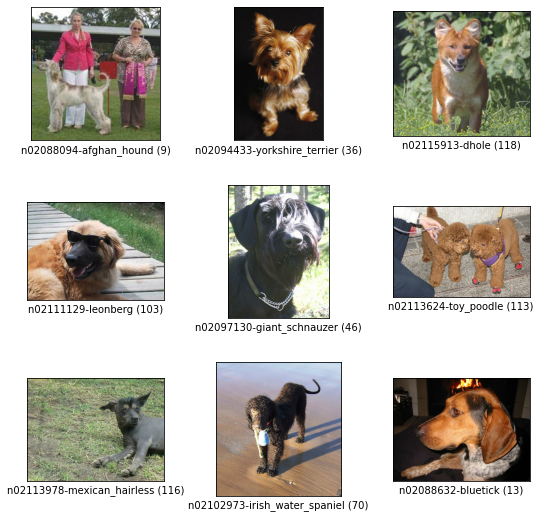

In [4]:
fig = tfds.show_examples(ds_train, ds_info)

# Plain resnet model과 base augmentation 비교하기 

## Augmentation을 적용한 데이터셋 만들기 

In [5]:
#기본적인 전처리 함수
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

- random_flip_left_right()과 random_brightness()를 활용

In [6]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image,label

- normalize, resize, augmentation과 shuffle을 적용

In [7]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

- Random Augmentation 직접 구현, 이미지 가운데 부분을 crop

In [8]:
def augment2(image,label):
    image = tf.image.central_crop(image, np.random.uniform(0.50, 1.00)) # 50%의 확률로 이미지 가운데 부분을 crop합니다.
    image = tf.image.resize(image, INPUT_SHAPE) # crop한 이미지를 원본 사이즈로 resize
    return image, label

- ResNet50 중 imagenet에 훈련된 모델을 불러오기

In [9]:
num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

- Augmentation을 적용한 데이터셋으로 학습시킬 ResNet을 하나 더 만듦.

In [10]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

- apply_normalize_on_dataset()에서 with_aug를 False로 주어 augmentation이 적용되지 않도록 하고, 다른 하나는 True로 주어 augmentation이 적용되도록 함.

In [11]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

- 두 개 모델에 각각 augmentation이 적용된 데이터셋과 적용되지 않은 데이터셋을 학습시키고, 검증을 진행함.

In [12]:
#EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
EPOCH = 20

tf.random.set_seed(2020)
resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

aug_resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 145s 155ms/step - loss: 3.1490 - accuracy: 0.2850 - val_loss: 3.1649 - val_accuracy: 0.2374
Epoch 2/20
750/750 [==============================] - 116s 155ms/step - loss: 0.9418 - accuracy: 0.7341 - val_loss: 1.1973 - val_accuracy: 0.6494
Epoch 3/20
750/750 [==============================] - 113s 150ms/step - loss: 0.3755 - accuracy: 0.9092 - val_loss: 1.0109 - val_accuracy: 0.7072
Epoch 4/20
750/750 [==============================] - 109s 145ms/step - loss: 0.1479 - accuracy: 0.9726 - val_loss: 0.9980 - val_accuracy: 0.7181
Epoch 5/20
750/750 [==============================] - 109s 145ms/step - loss: 0.0593 - accuracy: 0.9958 - val_loss: 0.9199 - val_accuracy: 0.7424
Epoch 6/20
750/750 [==============================] - 109s 145ms/step - loss: 0.0312 - accuracy: 0.9978 - val_loss: 0.9520 - val_accuracy: 0.7395
Epoch 7/20
750/750 [==============================] - 109s 145ms/step - loss: 0.0264 - accuracy: 0.9978 - val_loss: 0.9365 -

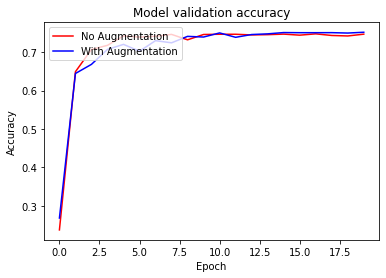

In [13]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.show()

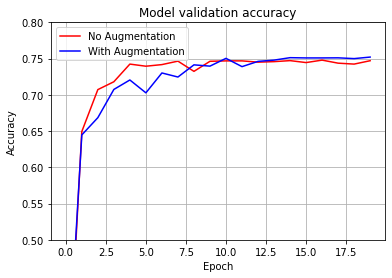

In [14]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
#plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

## Cutmix, Mixup Augmentation
- 맵 함수를 써서 위에 이미지에 적용한다. 라벨링을위해 onehot 인코딩을 한다. Augmentation을 하나의 이미지로만 했는데 이미지 한장을 Augmentation한거는 라벨이 안바뀐다. Cutmix는 이미지 혼합이라 라벨을 일정비율로 섞어준다. 이 데이터셋은 라벨이 120개이다. 잘라낸 비율만큼 라벨을 부여하기 위해 onehot 인코딩을 했다.

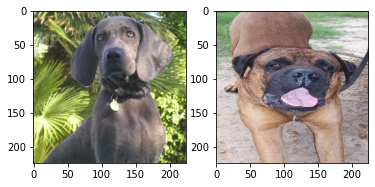

In [15]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

- 이 중 첫번째 이미지 a를 바탕 이미지로 하고 거기에 삽입할 두번째 이미지 b가 있을 때, a에 삽입될 영역의 바운딩 박스의 위치를 결정하는 함수를 구현하기

In [16]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast( tf.random.uniform([],0, image_size_x),tf.int32)
    y = tf.cast( tf.random.uniform([],0, image_size_y),tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)
    height = tf.cast(image_size_y * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)
    
    # clip box in image and get minmax bbox
    xa = tf.math.maximum(0, x-width//2)
    ya = tf.math.maximum(0, y-height//2)
    xb = tf.math.minimum(image_size_x, x+width//2)
    yb = tf.math.minimum(image_size_y, y+width//2)
    
    return xa, ya, xb, yb

xa, ya, xb, yb = get_clip_box(image_a, image_b)
print(xa, ya, xb, yb)

tf.Tensor(65, shape=(), dtype=int32) tf.Tensor(88, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)


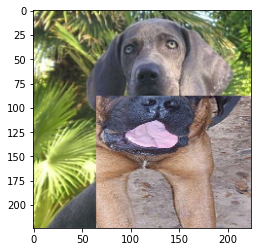

In [17]:
# mix two images
def mix_2_images(image_a, image_b, xa, ya, xb, yb):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:image_size_x,:]
    middle = tf.concat([one,two,three],axis=1)
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:image_size_y,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, xa, ya, xb, yb)
plt.imshow(mixed_img.numpy())

In [18]:
# mix two labels
def mix_2_label(label_a, label_b, xa, ya, xb, yb, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (xb-xa)*(yb-ya)
    total_area = image_size_x*image_size_y
    a = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-a)*label_a + a*label_b
    return mixed_label

mixed_label = mix_2_label(label_a, label_b, xa, ya, xb, yb)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.56903696, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

Q. 람다가 어차피 0~1 사이 값인데 뭐하러 1-람다를 사용하나?

라벨링할때 가중치 때문이다. 하나는 람다 하나는 1-람다를 해줘서 1-람다를 사용한다.

#### 오류해결
- 예제에 cutmix 함수의 return값이 mixed_label로 되어있어서 오류가 생겼다. mixed_labels로 바꾸어 오류를 해결했다.

In [19]:
def cutmix(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(label_a, label_b, xa, ya, xb, yb))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

## Mixup Augmentation
- 아래에서 직접 Mixup 함수를 구현

tf.Tensor(
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.5529437
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.4470563 0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0

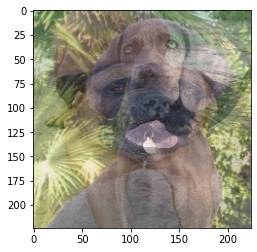

In [20]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    a = tf.random.uniform([],0,1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-a)*image_a + a*image_b
    mixed_label = (1-a)*label_a + a*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
print(mixed_label)

- 배치 단위의 mixup() 함수를 구현

In [21]:
def mixup(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [22]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image,label

AUTO = tf.data.experimental.AUTOTUNE

def onehot(image,label):
    CLASSES = 120
    return image,tf.one_hot(label,CLASSES)

def apply_normalize_on_dataset_cutmix(ds, is_test=False, batch_size=16, with_cutmix=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )

    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
        

    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds


def apply_normalize_on_dataset_mixup(ds, is_test=False, batch_size=16, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    
    ds = ds.batch(batch_size)
    if not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
        

    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [23]:
def apply_normalize_on_dataset_augmix(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

## 모델 학습하기

In [24]:
num_classes = ds_info.features["label"].num_classes

cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [25]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [26]:
augmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [27]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

ds_train_cutmix = apply_normalize_on_dataset_cutmix(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset_mixup(ds_train, with_mixup=True)

ds_test_cutmix = apply_normalize_on_dataset_cutmix(ds_test, is_test = True)
ds_test_mixup = apply_normalize_on_dataset_mixup(ds_test, is_test = True)

#### sparse_categorical_crossentropy() 대신 categorical_crossentropy() 를 사용하는 이유
- cutmix(), mixup()을 구현하면서 onehot인코딩을 통해 label의 mix 때문에 더이상 label이 스칼라값을 가지지 못하고 onehot 벡터 형태로 변환 되었기 때문이다.

In [28]:
EPOCH = 20


cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [29]:
history_cutmix_resnet50 = cutmix_resnet50.fit(
    ds_train_cutmix, # cutmix 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test_cutmix,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 116s 149ms/step - loss: 4.3751 - accuracy: 0.1098 - val_loss: 3.4931 - val_accuracy: 0.1795
Epoch 2/20
750/750 [==============================] - 111s 148ms/step - loss: 3.0501 - accuracy: 0.3967 - val_loss: 1.3950 - val_accuracy: 0.6199
Epoch 3/20
750/750 [==============================] - 112s 149ms/step - loss: 2.7163 - accuracy: 0.5127 - val_loss: 1.2537 - val_accuracy: 0.6516
Epoch 4/20
750/750 [==============================] - 111s 149ms/step - loss: 2.5113 - accuracy: 0.5790 - val_loss: 1.2233 - val_accuracy: 0.6580
Epoch 5/20
750/750 [==============================] - 111s 148ms/step - loss: 2.3749 - accuracy: 0.6182 - val_loss: 1.0891 - val_accuracy: 0.6975
Epoch 6/20
750/750 [==============================] - 111s 148ms/step - loss: 2.2343 - accuracy: 0.6501 - val_loss: 1.2542 - val_accuracy: 0.6629
Epoch 7/20
750/750 [==============================] - 111s 148ms/step - loss: 2.1436 - accuracy: 0.6938 - val_loss: 1.2108 -

In [30]:
history_mixup_resnet50 = mixup_resnet50.fit(
    ds_train_mixup, # mixup 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test_mixup,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 117s 150ms/step - loss: 4.2825 - accuracy: 0.1243 - val_loss: 4.5549 - val_accuracy: 0.0525
Epoch 2/20
750/750 [==============================] - 112s 150ms/step - loss: 2.9986 - accuracy: 0.4243 - val_loss: 1.5073 - val_accuracy: 0.5847
Epoch 3/20
750/750 [==============================] - 112s 150ms/step - loss: 2.6630 - accuracy: 0.5474 - val_loss: 1.3643 - val_accuracy: 0.6186
Epoch 4/20
750/750 [==============================] - 112s 150ms/step - loss: 2.4668 - accuracy: 0.6229 - val_loss: 1.2713 - val_accuracy: 0.6462
Epoch 5/20
750/750 [==============================] - 112s 150ms/step - loss: 2.3415 - accuracy: 0.6780 - val_loss: 1.2701 - val_accuracy: 0.6503
Epoch 6/20
750/750 [==============================] - 112s 149ms/step - loss: 2.2259 - accuracy: 0.7125 - val_loss: 1.1829 - val_accuracy: 0.6753
Epoch 7/20
750/750 [==============================] - 112s 149ms/step - loss: 2.0952 - accuracy: 0.7538 - val_loss: 1.3585 -

## 훈련과정 시각화 하기

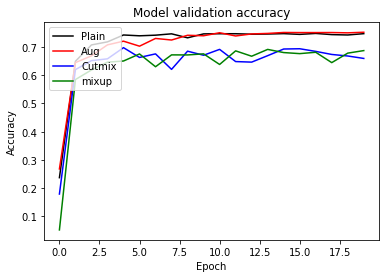

In [32]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'k')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'r')
plt.plot(history_cutmix_resnet50.history['val_accuracy'], 'b')
plt.plot(history_mixup_resnet50.history['val_accuracy'], 'g')

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Plain', 'Aug', 'Cutmix', 'mixup'], loc='upper left')
plt.show()

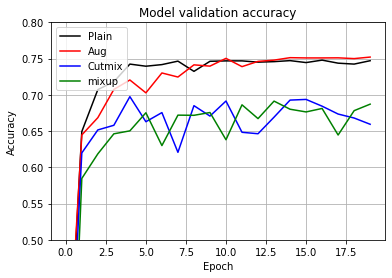

In [37]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'k')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'r')
plt.plot(history_cutmix_resnet50.history['val_accuracy'], 'b')
plt.plot(history_mixup_resnet50.history['val_accuracy'], 'g')

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Plain', 'Aug', 'Cutmix', 'mixup'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
#plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

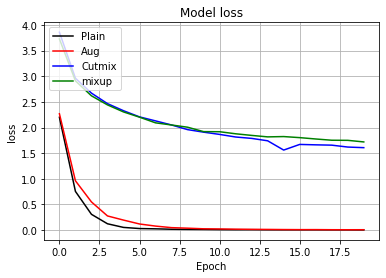

In [36]:
plt.plot(history_resnet50_no_aug.history['loss'], 'k')
plt.plot(history_resnet50_aug.history['loss'], 'r')
plt.plot(history_cutmix_resnet50.history['loss'], 'b')
plt.plot(history_mixup_resnet50.history['loss'], 'g')
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Plain', 'Aug', 'Cutmix', 'mixup'], loc='upper left')
plt.grid(True)
#plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
#plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

## Augmentation에 의한 모델 성능 비교
- Plain, Base Augmentation한 resnet모델이 성능이 좋게나왔고 cutmix, mixup한 모델은 성능이 보다 떨어졌다.
- 데이터셋이 어떤 특징을 가지냐에 따라 cutmix, mixup한 데이터셋이 단점이 될 수 있고 장점이 될 수 있을 것 같다.
- 실험한 데이터셋인 'stanford_dogs'은 강아지들이 다 비슷한 면이 있어서 'cats_vs_dogs'데이터셋이나 'cifar-10'데이터셋에 cutmix, mixip 을 적용하면 성능향상 결과가 나올수도 있을 것 같다.

# 마치며...
- 예제에서 utmix 함수의 return값 변수에 s가 빠져있어서 좀 헤맸지만 그래도 오류해결을 했을 때 행복했다.
- 아쉽게도 cutmix, mixup을 통해 성능향상을 못하였다.
- 그래도 모든 모델들의 accuracy, loss가 잘 수렴하여 다행이다.
- 상식적으로 cutmix, mixup이 막 섞는것인데 막섞는다고 성능이 좋아지진 않을 것 같다. cutmix, mixup한 이미지를 일부만 조금 넣는다거나 하면 성능 향상을 기대할 수 있을 것 같다.